In [35]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Metrics

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def minkowski_distance(a, b, p):
    return np.sum(np.abs(a - b) ** p) ** (1 / p)


def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [ ]:
# Kernels

def uniform_kernel(u):
    return 1 / 2 * (u < 1)


def gaussian_kernel(u):
    return np.exp(-(u ** 2) / 2) / (np.sqrt(2 * np.pi))


def triangular_kernel(u):
    return (1 - np.abs(u)) * (u < 1)


def epanechnikov_kernel(u):
    return 3 / 4 * (1 - u ** 2) * (u < 1)

In [ ]:
def non_param_regr_fixed_size(u, x_train, y_train, h, metric, kernel):
    classes = np.unique(y_train)
    class_votes = {c: 0 for c in classes}

    for xi, yi in zip(x_train, y_train):
        weight = kernel(metric(u, xi) / h)

        class_votes[yi] += weight

    return max(class_votes, key=class_votes.get)


def non_param_regr_non_fixed_size(u, x_train, y_train, k, metric, kernel):  # k - количество соседей
    classes = np.unique(y_train)
    class_votes = {c: 0 for c in classes}
    kth_nearest_object = get_nth_nearest_object(u, k + 1, metric, x_train)

    for xi, yi in zip(x_train, y_train):
        weight = kernel(metric(u, xi) / metric(u, kth_nearest_object))

        class_votes[yi] += weight
        # У xi класс yi
        # Тогда xi добавляет уверенности для u в классе yi на weight

    return max(class_votes, key=class_votes.get)
    # Возвращаем класс в котором больше всего уверены


In [ ]:
from sklearn.neighbors import NearestNeighbors


def get_n_nearest_objects(u, n, metric, d_train):
    # d_train = np.array(d_train).reshape(-1, 1)
    nearest_neighbours = NearestNeighbors(n_neighbors=n, metric=metric).fit(d_train)
    indices = nearest_neighbours.kneighbors([u], return_distance=False)
    return np.array([d_train[i] for i in indices])


def get_nth_nearest_object(u, n, metric, d_train):
    return get_n_nearest_objects(u, n, metric, d_train)[-1][-1]

In [ ]:
euclidean_distance(4, 2)

In [ ]:
def knn_predict(X_train, Y_train, x_test, k, metric, kernel, fixed_size_window=False, h=None):
    # Для каждого элемента из x_test подбираем метку с помощью non_parametric_regr
    c = 0
    result_labels = []
    for u in x_test:
        if fixed_size_window and h is not None:
            label = non_param_regr_fixed_size(u, X_train, Y_train, h, metric, kernel)
        elif fixed_size_window:
            raise RuntimeError("You should specify h for fixed size window")
        else:
            label = non_param_regr_non_fixed_size(u, X_train, Y_train, k, metric, kernel)
        result_labels.append(label)
        c += 1
    return result_labels

### Load data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('data.csv')

# Избавляемся от дизбаланса классов, выбрав подмножество с одинаковым количеством категорий
grouped = data.groupby('Категория')

filtered_data = []

for category, group in grouped:
    sampled_group = group.sample(n=1610, random_state=42)
    filtered_data.append(sampled_group)

data = pd.concat(filtered_data)

print(data['Категория'].value_counts())

data_encoded = pd.get_dummies(data, columns=['Страна'], dtype=int)

X = data_encoded.drop(columns=['Категория', 'Название'])
y = data_encoded['Категория']

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Optimize params

In [28]:
def objective(trial):
    metric = trial.suggest_categorical('metric', (cosine_distance, euclidean_distance, minkowski_distance))
    if metric is minkowski_distance:
        p = trial.suggest_float("p", 0.0, 1.0)
        metric = lambda a, b: minkowski_distance(a, b, p)
    kernel = trial.suggest_categorical('kernel',
                                       (uniform_kernel, gaussian_kernel, triangular_kernel, epanechnikov_kernel))
    k = trial.suggest_int('n_neighbors', 10, 400)
    is_fixed_window = trial.suggest_categorical('fixed_size_window', (True, False))
    if is_fixed_window:
        h = trial.suggest_int("h", 1, k)
    else:
        h = None

    y_pred = knn_predict(X_train, y_train, X_val, k, metric, kernel, fixed_size_window=is_fixed_window, h=h)

    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [29]:
import warnings

warnings.filterwarnings('ignore')

In [30]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Лучшие параметры:")
print(study.best_params)
print("Лучшее значение метрики:")
print(study.best_value)

[I 2024-03-09 15:46:55,051] A new study created in memory with name: no-name-b6f1b292-9a2a-427f-8132-bee8433e5c8a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-09 15:47:16,259] Trial 0 finished with value: 0.19627329192546583 and parameters: {'metric': <function minkowski_distance at 0x2b4e6fc10>, 'p': 0.043840254011957125, 'kernel': <function triangular_kernel at 0x2b4e6f8b0>, 'n_neighbors': 149, 'fixed_size_window': True, 'h': 121}. Best is trial 0 with value: 0.19627329192546583.
[I 2024-03-09 15:48:12,004] Trial 1 finished with value: 0.5204968944099378 and parameters: {'metric': <function minkowski_distance at 0x2b4e6fc10>, 'p': 0.43272759842384967, 'kernel': <function triangular_kernel at 0x2b4e6f8b0>, 'n_neighbors': 350, 'fixed_size_window': False}. Best is trial 1 with value: 0.5204968944099378.
[I 2024-03-09 15:48:32,218] Trial 2 finished with value: 0.1937888198757764 and parameters: {'metric': <function cosine_distance at 0x2b4e6fdc0>, 'kernel': <function epanechnikov_kernel at 0x2b4e6faf0>, 'n_neighbors': 267, 'fixed_size_window': True, 'h': 103}. Best is trial 1 with value: 0.5204968944099378.
[I 2024-03-09 15:49:19,06

In [38]:
y_pred = knn_predict(X_train, y_train.values, X_test, 12, lambda a, b: minkowski_distance(a, b, 0.195), kernel=triangular_kernel)

In [39]:
accuracy_score(y_test.values, y_pred)

0.591304347826087

In [77]:
import matplotlib.pyplot as plt


def plot_knn_accuracy(max_neighbors, step, x_test_set, y_test_set):
    neighbors = np.arange(1, max_neighbors+1, step)
    accuracies = []

    for k in neighbors:
        print(k)
        y_pred = knn_predict(X_train, y_train, x_test_set, k, lambda a, b: minkowski_distance(a, b, 0.195), kernel=triangular_kernel)
        accuracy = accuracy_score(y_test_set, y_pred)

        accuracies.append(accuracy)

    # Строим график зависимости числа соседей от accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(neighbors, accuracies, marker='o', linestyle='-')
    plt.title('Зависимость точности от числа соседей')
    plt.xlabel('Число соседей')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391


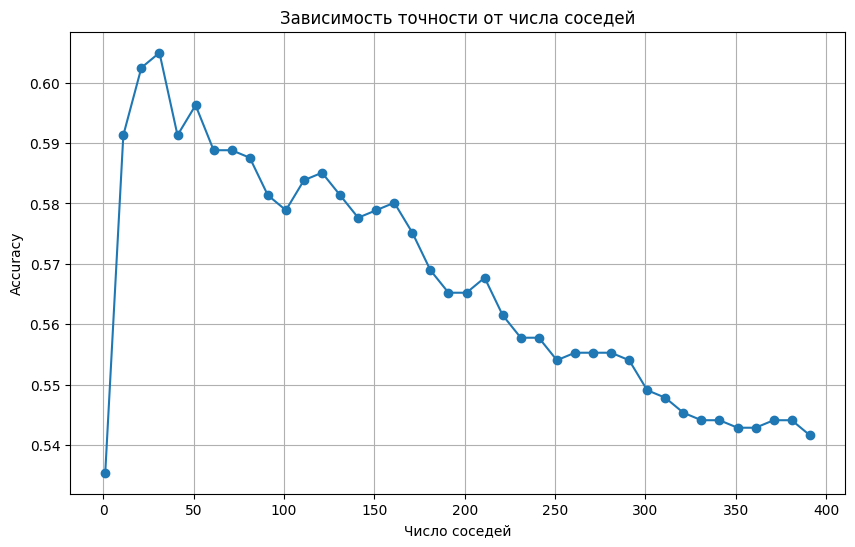

In [72]:
plot_knn_accuracy(400, 10, X_test, y_test)

1
11
21
31
41
51
61
71
81
91


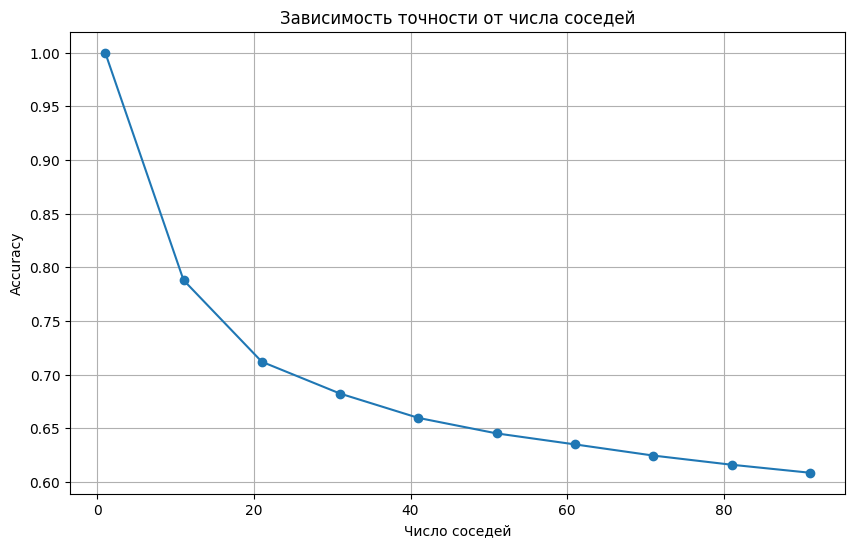

In [79]:
plot_knn_accuracy(100, 10, X_train, y_train)

## Dummy predict

In [34]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="uniform")
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
accuracy_score(dummy_pred, y_test)

0.20496894409937888

In [ ]:
def knn_for_lowess(u, x_train, k, metric, kernel):
    classes = np.unique(y_train)
    class_votes = {c: 0 for c in classes}
    kth_nearest_object = get_nth_nearest_object(u, k + 1, metric, x_train)

    for xi, yi in zip(x_train, y_train):
        if np.array_equal(xi, u):
            continue
        weight = kernel(metric(u, xi) / metric(u, kth_nearest_object))

        class_votes[yi] += weight

    return class_votes

## LOWESS

In [ ]:
def lowess(x_train, y_train, alg, kernel):
    # alg - принимает текущий элемент и тестовое множество и возвращает словарь вида (класс: уверенность)
    c = 0
    weights = []
    for xi, yi in zip(x_train, y_train):
        if c % 100 == 0:
            print(c)
        res_dict = alg(xi, x_train)
        confidence = res_dict[yi] / sum(res_dict.values())
        wi = kernel(1 - confidence)
        weights.append(wi)
        c += 1
    return np.array(weights)

In [ ]:
weights = lowess(
    X_train,
    y_train,
    lambda u, xt: knn_for_lowess(u, xt, 10, euclidean_distance, epanechnikov_kernel),
    epanechnikov_kernel
)
weights

In [ ]:
pred_lowess = knn_predict(weights.reshape(-1, 1) * X_train, y_train, X_test, 15, euclidean_distance,
                          epanechnikov_kernel)

In [ ]:
accuracy_score(pred_lowess, y_test)

### Библиотечная реализация с LOWESS

In [ ]:
model = KNeighborsClassifier(weights=weights)
model.fit(X_train, y_train)

In [ ]:
pred_sklearn_lowess = model.predict(X_test)
accuracy_score(pred_sklearn_lowess, y_test)

### Optimize params for sklearn knn

In [53]:
def objective_for_sklearn(trial):
    metric = trial.suggest_categorical('metric', ('minkowski', 'euclidean', 'cosine'))
    p = trial.suggest_float("p", 0, 3.0)
    k = trial.suggest_int('n_neighbors', 10, 400)

    model = KNeighborsClassifier(n_neighbors=k, metric=metric, p=p)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

In [54]:
study_sklearn = optuna.create_study(direction='maximize')
study_sklearn.optimize(objective_for_sklearn, n_trials=100, show_progress_bar=True)

print("Лучшие параметры:")
print(study_sklearn.best_params)
print("Лучшее значение метрики:")
print(study_sklearn.best_value)

[I 2024-03-09 17:42:51,889] A new study created in memory with name: no-name-1b514579-adb9-4847-b07b-46c5e27e7cf5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-09 17:42:52,186] Trial 0 finished with value: 0.47577639751552797 and parameters: {'metric': 'minkowski', 'p': 2.794751127658377, 'n_neighbors': 204}. Best is trial 0 with value: 0.47577639751552797.
[I 2024-03-09 17:42:52,390] Trial 1 finished with value: 0.462111801242236 and parameters: {'metric': 'cosine', 'p': 1.1224104317007888, 'n_neighbors': 84}. Best is trial 0 with value: 0.47577639751552797.
[I 2024-03-09 17:42:52,809] Trial 2 finished with value: 0.4745341614906832 and parameters: {'metric': 'minkowski', 'p': 1.3978243437636033, 'n_neighbors': 235}. Best is trial 0 with value: 0.47577639751552797.
[I 2024-03-09 17:42:52,866] Trial 3 finished with value: 0.47701863354037266 and parameters: {'metric': 'euclidean', 'p': 1.9001695909348695, 'n_neighbors': 203}. Best is trial 3 with value: 0.47701863354037266.
[I 2024-03-09 17:42:53,029] Trial 4 finished with value: 0.43975155279503103 and parameters: {'metric': 'cosine', 'p': 2.7294459095428873, 'n_neighbors': 134}. 

### Библиотечная реализация knn

In [55]:
model = KNeighborsClassifier(n_neighbors=19, metric='minkowski', p=0.078)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19, p=0.078)

In [56]:
pred_sklearn = model.predict(X_test)
accuracy_score(pred_sklearn, y_test)

0.5888198757763975

In [73]:
def plot_knn_accuracy_sklearn(max_neighbors, step, x_test_set, y_test_set):
    neighbors = np.arange(1, max_neighbors+1, step)
    accuracies = []

    for k in neighbors:
        print(k)
        model = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=0.078)
        model.fit(X_train, y_train)
        y_pred = model.predict(x_test_set)
        accuracy = accuracy_score(y_test_set, y_pred)

        accuracies.append(accuracy)

    plt.figure(figsize=(10, 6))
    plt.plot(neighbors, accuracies, marker='o', linestyle='-')
    plt.title('Зависимость точности от числа соседей')
    plt.xlabel('Число соседей')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391


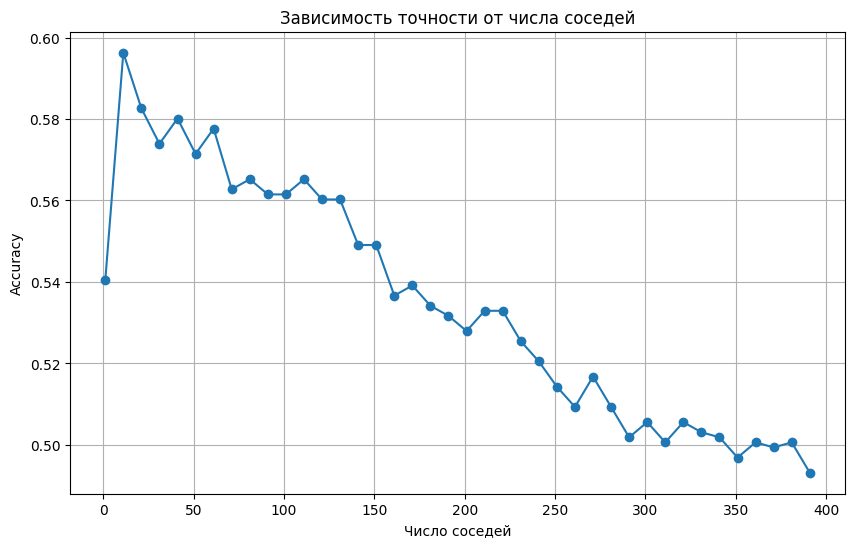

In [75]:
plot_knn_accuracy_sklearn(400, 10, X_test, y_test)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391


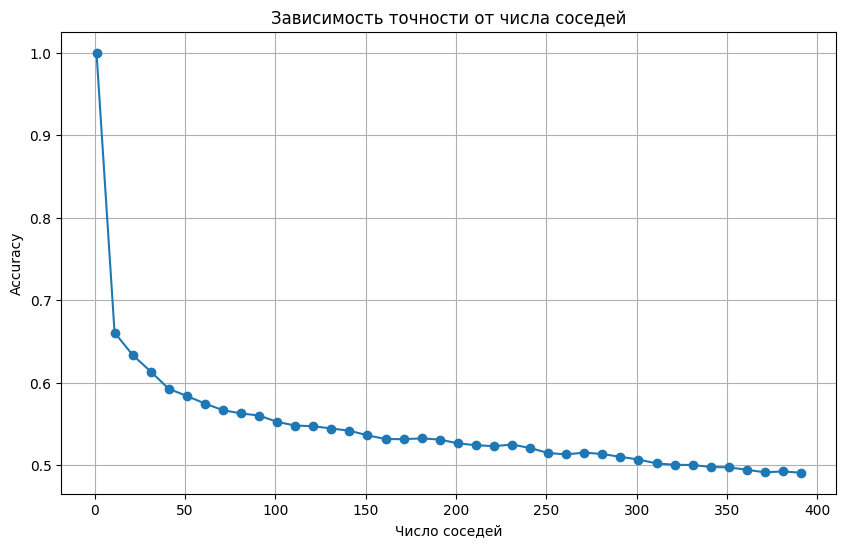

In [76]:
plot_knn_accuracy_sklearn(400, 10, X_train, y_train)